In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pyriemann
from pyriemann.datasets.sampling import _sample_parameter_r
import time

## Speeding up our sampling of Gaussian SPD matrices

When sampling a $m$-dimensional SPD matrix from a Riemannian Gaussian distribution centered at $I_m$ and with dispersion $\sigma$, we split the problem into two parts. Calling this matrix $Y$ and using its polar decomposition denoted by:

$$
Y = U~\text{diag}(\exp(r_1, \dots, r_m))~U^T
$$

we first sample orthogonal matrix $U$ uniformly from the space of orthogonal matrices $\mathcal{O}(m)$ as per:
1. Sample matrix $A \in \mathbb{R}^{m \times m}$, where $A_{ij} \sim \mathcal{N}(0, 1)$
2. Apply QR factorization to obtain $A = QR$
3. Matrix $Q$ is uniformly distributed on $\mathcal{O}(m)$

Then, we sample the vector of log-eigenvalues $r = (r_1, \dots, r_m)$ from the probability distribution

$$
p(r) = \dfrac{1}{Z(m, \sigma)} \exp\left(-\frac{1}{2\sigma^2}\sum_{i = 1}^m r^2_i\right) \times \prod_{i < j}\sinh\left(|r_i - r_j|/2\right)
$$

which has to be done via some computational method. At the moment, `pyriemann` uses a slice sampling approach [[1]](https://projecteuclid.org/journals/annals-of-statistics/volume-31/issue-3/Slice-sampling/10.1214/aos/1056562461.full) for obtaining samples from $p(r)$ but this is rather slow. I propose we change the implementation to a rejection sampling approach [[2]](https://en.wikipedia.org/wiki/Rejection_sampling), exploring some of the properties of $p$ and therefore obtaining better performance.

### The 2D case

We start our exploration with the simplest of cases, that of $m = 2$. The pdf for $r = (r_1, r_2)$ simplifies to:

$$
\begin{array}{rcl}
p(r_1, r_2) &=& \dfrac{1}{Z(2, \sigma)}\exp\left(-\dfrac{1}{2\sigma^2}(r_1^2 + r_2^2)\right) \times \sinh\left(|r_1 - r_2|/2\right) \\[1em]
&=& \dfrac{1}{Z(2, \sigma)}\exp\left(-\dfrac{1}{2\sigma^2}(r_1^2 + r_2^2)\right) \times \Big(\mathbf{1}_{\{r_1 - r_2 \geq 0\}}\sinh\left((r_1 - r_2)/2\right) + \mathbf{1}_{\{r_1 - r_2 < 0\}}\sinh\left((r_2 - r_1)/2\right) \Big)
\end{array}
$$

we can see this pdf as a mixture of two components depending of a binary variable $b$

$$
p(r) = p(r \mid b = 0) \times \mathbb{P}(b = 0) + p(r \mid b = 1) \times \mathbb{P}(b = 1)
$$

with $\mathbb{P}(b = 0) = \mathbb{P}(b = 1) = 1/2$ and

$$
p(r \mid b = 0) = \dfrac{2}{Z(2, \sigma)}\exp\left(-\dfrac{1}{2\sigma^2}(r_1^2 + r_2^2)\right) \times \mathbf{1}_{\{r_1 - r_2 \geq 0\}}\sinh\left((r_1 - r_2)/2\right)
$$
and
$$
p(r \mid b = 1) = \dfrac{2}{Z(2, \sigma)}\exp\left(-\dfrac{1}{2\sigma^2}(r_1^2 + r_2^2)\right) \times \mathbf{1}_{\{r_1 - r_2 < 0\}}\sinh\left((r_2 - r_1)/2\right)
$$

So we see that to generate a sample from $p(r)$ we can first generate a Bernoulli variable $b \sim \mathcal{B}(1/2)$ and then sample from one of the conditional distributions. 

Let's see how we would sample from $p(r \mid b = 0)$ using rejection sampling. First, we we would need to find a nice pdf that is an upper bound to it. Note that for $r_1 - r_2 > 0$ we have

$$
\sinh\left((r_1 - r_2)/2\right) = 1/2\exp\big((r_1 - r_2)/2\big) - 1/2\exp\big(-(r_1 - r_2)/2\big) \leq 1/2\exp\big((r_1 - r_2)/2\big)
$$

so we can write

$$
\begin{array}{rcl}
p(r \mid b = 0) &\leq& \dfrac{1}{Z(2, \sigma)} \exp\left(-\dfrac{1}{2\sigma^2}(r_1^2 + r_2^2)\right) \times \mathbf{1}_{\{r_1 - r_2 \geq 0\}}\exp\big((r_1 - r_2)/2\big) \\[1em]
&\leq& \dfrac{2\pi\sigma^2 \exp(\sigma^2/4)}{Z(2, \sigma)} \times \dfrac{1}{2\pi \sigma^2}\exp\left(-\dfrac{1}{2\sigma^2}\Big(\big(r_1-\sigma^2/2\big)^2 + \big(r_2+\sigma^2/2\big)^2\Big)\right)
\end{array}
$$

The results above indicate that if we want to sample from $p(r \mid b = 0)$ we can do it via rejection sampling using as auxiliary distribution 

$$
g_0(r) = \dfrac{1}{2\pi \sigma^2}\exp\left(-\dfrac{1}{2\sigma^2}\Big(\big(r_1-\sigma^2/2\big)^2 + \big(r_2+\sigma^2/2\big)^2\Big)\right)
$$

the algorithm goes as follows:
1. Sample $u \sim \mathcal{U}(0, 1)$ and $r \sim g_0(r)$

2. Check whether 
$$
u < \mathbf{1}_{r_1 - r_2 \geq 0}~\exp\left(-\dfrac{1}{2\sigma^2}(r_1^2+r_2^2)\right)\sinh((r_1 - r_2)/2)\times\dfrac{1}{M g_0(r)}
$$

- If this holds, then accept $r$ as a sample from $p(r \mid b = 0)$
- If not, reject the sample

Where $M = \pi\sigma^2 \exp(\sigma^2/4)$

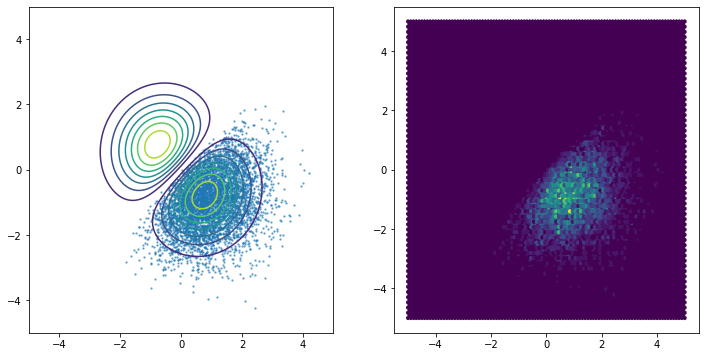

In [4]:
n_samples = 10_000
sigma = 1.0

mu0 = np.array([sigma**2/2, -sigma**2/2])
cv0 = (sigma**2)*np.eye(2)

u = np.random.rand(n_samples)
r0_candidates = multivariate_normal.rvs(
    mean=mu0, 
    cov=cv0, 
    size=n_samples)

def t0(r, s):
    mu0 = np.array([s**2/2, -s**2/2])
    cv0 = s**2*np.eye(2)    
    if (r[0] - r[1]) < 0:
        return 0
    else:
        M = np.pi*(s**2)*np.exp(s**2/4)
        num = np.exp(-1/(2*s**2) * np.sum(r**2)) * np.sinh((r[0] - r[1])/2) * 1/M
        den = multivariate_normal.pdf(r, mean=mu0, cov=cv0)
        return num / den
    
t = np.array([t0(ri, sigma) for ri in r0_candidates])
r0 = r0_candidates[u < t]

T = 5
rx = np.linspace(-T, T, 200)
ry = np.linspace(-T, T, 200)
RX, RY = np.meshgrid(rx, ry)

F = np.exp(-1/(2*sigma**2)*(RX**2 + RY**2)) * np.sinh(np.abs(RX - RY)/2)

fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
ax[0].contour(RX, RY, F)
ax[0].scatter(r0[:,0],r0[:,1], s=2, alpha=0.5)
ax[1].hexbin(r0[:,0], r0[:,1], extent=(-T, T, -T, T))
plt.show()

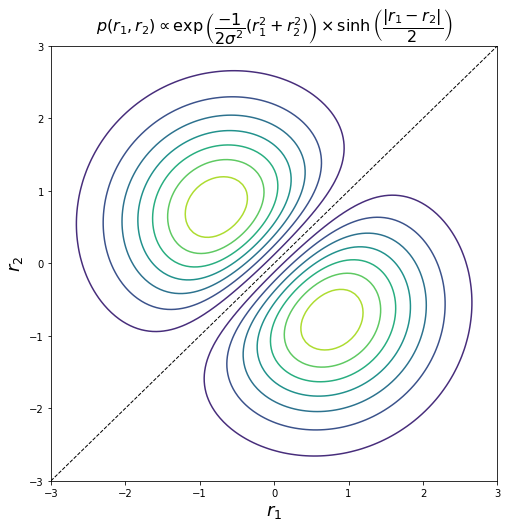

In [55]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.contour(RX, RY, F)
ax.set_xlabel(r'$r_1$', fontsize=18)
ax.set_ylabel(r'$r_2$', fontsize=18)
ax.set_xlim(-3, +3)
ax.set_ylim(-3, +3)
ax.plot([-3, 3], [-3, 3], ls='--', c='k', lw=1.0)
ax.set_title(r'$p(r_1, r_2) \propto \exp\left(\dfrac{-1}{2\sigma^2}(r_1^2 + r_2^2)\right) \times \sinh\left(\dfrac{|r_1 - r_2|}{2}\right)$', fontsize=16)
plt.show()

Great, looks like we are able to sample from the lower part of the pdf. 

The upper part has a similar expression for its bounding function as per

$$
g_1(r) = \dfrac{1}{2\pi \sigma^2}\exp\left(-\dfrac{1}{2\sigma^2}\Big(\big(r_1+\sigma^2/2\big)^2 + \big(r_2-\sigma^2/2\big)^2\Big)\right)
$$

and running its corresponding rejection sampling algorithm gives us

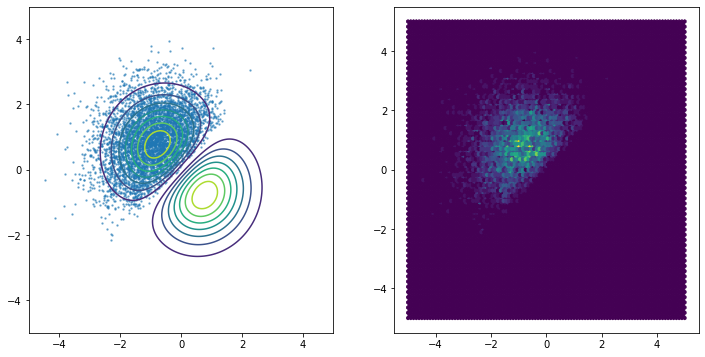

In [4]:
N = 10_000
s = 1.0
u = np.random.rand(N)

mu1 = np.array([-s**2/2, s**2/2])
cv1 = s**2*np.eye(2)
r1_candidates = multivariate_normal.rvs(
    mean=mu1, 
    cov=cv1, 
    size=N)

def t1(r, s):
    mu1 = np.array([-s**2/2, s**2/2])
    cv1 = s**2*np.eye(2)    
    if (r[1] - r[0]) < 0:
        return 0
    else:
        M = np.pi*(s**2)*np.exp(s**2/4)
        num = np.exp(-1/(2*s**2) * np.sum(r**2)) * np.sinh((r[1] - r[0])/2) * 1/M
        den = multivariate_normal.pdf(r, mean=mu1, cov=cv1)
        return num / den
    
t = np.array([t1(ri, s) for ri in r1_candidates])
r1 = r1_candidates[u < t]

T = 5
rx = np.linspace(-T, T, 200)
ry = np.linspace(-T, T, 200)
RX, RY = np.meshgrid(rx, ry)

F = np.exp(-1/(2*s**2)*(RX**2 + RY**2)) * np.sinh(np.abs(RX - RY)/2)

fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
ax[0].contour(RX, RY, F)
ax[0].scatter(r1[:,0], r1[:,1], s=2, alpha=0.5)
ax[1].hexbin(r1[:,0], r1[:,1], extent=(-T, T, -T, T))
plt.show()

We are now ready to propose a unified algorithm for sampling from the full pdf $p(r)$ as:

1. Sample $u \sim \mathcal{U}(0, 1)$ and $b \sim \mathcal{B}(1/2)$

2. Sample $r \sim g_b(r)$ where:

$$
g_0(r) = \dfrac{1}{2\pi \sigma^2}\exp\left(-\dfrac{1}{2\sigma^2}\Big(\big(r_1-\sigma^2/2\big)^2 + \big(r_2+\sigma^2/2\big)^2\Big)\right)
$$
and
$$
g_1(r) = \dfrac{1}{2\pi \sigma^2}\exp\left(-\dfrac{1}{2\sigma^2}\Big(\big(r_1+\sigma^2/2\big)^2 + \big(r_2-\sigma^2/2\big)^2\Big)\right)
$$


3. Check whether 
$$
u < \dfrac{Z(2,\sigma)p(r \mid b)}{2M g_b(r)}
$$

- If this holds, then accept $r$ as a sample from $p(r)$
- If not, reject the sample

Where $M = \pi\sigma^2 \exp(\sigma^2/4)$

NB: Both expressions for $p(r \mid b)$ have $Z(2,\sigma)$ on the denominator, so we don't really need to calculate it.

In [5]:
N = 10_000
s = 1.0
T = 10

b = np.random.binomial(1, 0.5, N)
mu0 = np.array([s**2/2, -s**2/2])
cv0 = s**2*np.eye(2)
mu1 = np.array([-s**2/2, s**2/2])
cv1 = s**2*np.eye(2)

u0 = np.random.rand(sum(b > 0))
r0_candidates = multivariate_normal.rvs(
    mean=mu0, 
    cov=cv0, 
    size=sum(b > 0))
u1 = np.random.rand(N - sum(b > 0))
r1_candidates = multivariate_normal.rvs(
    mean=mu1, 
    cov=cv1, 
    size=N - sum(b > 0))

def test0(r, s):
    mu0 = np.array([s**2/2, -s**2/2])
    cv0 = s**2*np.eye(2)    
    if (r[0] - r[1]) < 0:
        return 0
    else:
        M = np.pi*(s**2)*np.exp(s**2/4)
        num = np.exp(-1/(2*s**2) * np.sum(r**2)) * np.sinh((r[0] - r[1])/2) * 1/M
        den = multivariate_normal.pdf(r, mean=mu0, cov=cv0)
        return num / den

def test1(r, s):
    mu1 = np.array([-s**2/2, s**2/2])
    cv1 = s**2*np.eye(2)    
    if (r[1] - r[0]) < 0:
        return 0
    else:
        M = np.pi*(s**2)*np.exp(s**2/4)
        num = np.exp(-1/(2*s**2) * np.sum(r**2)) * np.sinh((r[1] - r[0])/2) * 1/M
        den = multivariate_normal.pdf(r, mean=mu1, cov=cv1)
        return num / den

t0 = np.array([test0(ri, s) for ri in r0_candidates])
r0 = r0_candidates[u0 < t0]
cpt = 0
for elt in t0:
    if elt == 0:
        cpt+=1
print(cpt)
t1 = np.array([test1(ri, s) for ri in r1_candidates])
r1 = r1_candidates[u1 < t1]
r = np.concatenate([r0, r1])

# rx = np.linspace(-T, T, 200)
# ry = np.linspace(-T, T, 200)
# RX, RY = np.meshgrid(rx, ry)

# F = np.exp(-1/(2*s**2)*(RX**2 + RY**2)) * np.sinh(np.abs(RX - RY)/2)

# fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
# ax[0].contour(RX, RY, F)
# ax[0].scatter(r[:,0], r[:,1], s=2, alpha=0.5)
# ax[1].hexbin(r[:,0], r[:,1], extent=(-T, T, -T, T))
# plt.show()

1165


In [4]:
print(np.shape(r))

(5157, 2)


## The 3D case

Before tackling the $m$-dimensional case, I will consider a slightly harder instance, that of three dimensional SPD matrices.

In this case, we have that

$$
p(r) = \dfrac{1}{Z(3,\sigma)}\exp\left(-\frac{1}{2\sigma^2}\Big(r_1^2+r_2^2+r_3^2\Big)\right) \times \sinh\left(\dfrac{|r_1 - r_2|}{2}\right) \times \sinh\left(\dfrac{|r_1 - r_3|}{2}\right) \times \sinh\left(\dfrac{|r_2 - r_3|}{2}\right)
$$

By defining three bernoulli random variables $b_{12}, b_{13}, b_{23} \sim \mathcal{B}(1/2)$ we can rewrite the pdf as

$$
p(r) = \sum_{b \in \mathbf{B}} p(r \mid b) p(b) = \dfrac{1}{8}\sum_{b \in \mathbf{B}} p(r \mid b[1] = b_{12}, b[2] = b_{13}, b[3] = b_{23})
$$

where $\mathbf{B}$ is the set of all binary vectors with $m = 3$ coordinates, i.e. $\mathbf{B} = \{[0, 0, 0], [0, 0, 1], \dots, [1, 1, 1]\}$, and the values of each coordinate of $b$ will determine which components $r_i - r_j$ are greater or smaller than zero.

For instance, 

$$
p(r \mid b = [0, 0, 0]) = \dfrac{8}{Z(3,\sigma)}\exp\left(-\frac{1}{2\sigma^2}\Big(r_1^2+r_2^2+r_3^2\Big)\right) \times \prod_{i < j} \sinh\left(\dfrac{r_i - r_j}{2}\right)
$$

noting that each $\sinh$ can be majorized by $1/2$ times an exponential function, we can write

$$
p(r \mid b = [0, 0, 0]) \leq \dfrac{4}{Z(3,\sigma)}\exp\left(-\frac{1}{2\sigma^2}\Big(r_1^2+r_2^2+r_3^2\Big)\right) \times \prod_{i < j} \exp\left(\dfrac{r_i - r_j}{2}\right)
$$

The expression can be simplified if we note that

$$
\begin{array}{rcl}
-\dfrac{1}{2\sigma^2}\Big(r_1^2+r_2^2+r_3^2\Big) + \displaystyle\sum_{i < j} \dfrac{(r_i - r_j)}{2} = -\frac{1}{2\sigma^2}\Big((r_1 - \sigma^2)^2 + r_2^2 + (r_3 + \sigma^2)^2 \Big) + \sigma^2
\end{array}
$$

so we obtain

$$
p(r \mid b = [0, 0, 0]) \leq \dfrac{4(2\pi \sigma^2)^{3/2}\exp(\sigma^2)}{Z(3,\sigma)} \times \dfrac{1}{(2\pi \sigma^2)^{3/2}} \exp\left(-\frac{1}{2\sigma^2}\Big((r_1 - \sigma^2)^2 + r_2^2 + (r_3 + \sigma^2)^2 \Big)\right)
$$

2.0735490322113037


/var/folders/1r/syrjmt51115cyrdggjbwqv6h0000gn/T/ipykernel_36114/2844340131.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


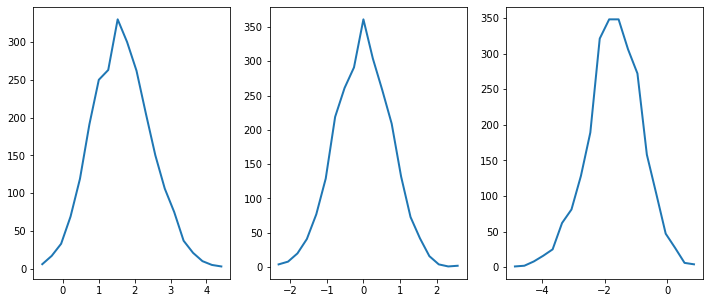

In [24]:
tini = time.time()
N = 100_000
s = 1.0
u = np.random.rand(N)

mu000 = np.array([s**2, 0, -s**2])
cv000 = s**2*np.eye(3)
r000_candidates = multivariate_normal.rvs(mean=mu000, cov=cv000, size=N)

def t000(r, s):
    mu000 = np.array([s**2, 0, -s**2])
    cv000 = s**2*np.eye(3)
    if ( (r[0] - r[1]) < 0 ) or ( (r[0] - r[2]) < 0 ) or ( (r[1] - r[2]) < 0 ):
        return 0
    else:
        M = (2*np.pi*(s**2))**(3/2)*np.exp(s**2)
        num = np.exp(-1/(2*s**2) * np.sum(r**2)) * np.sinh((r[0] - r[1])/2) * 1/M
        num = num * np.sinh((r[0] - r[2])/2) * np.sinh((r[1] - r[2])/2)
        den = multivariate_normal.pdf(r, mean=mu000, cov=cv000)
        return num / den
    
t = np.array([t000(ri, s) for ri in r000_candidates])
r000 = r000_candidates[u < t]

tend = time.time()
print(tend-tini)

fig, ax = plt.subplots(figsize=(12,5), ncols=3)
for i in range(3):
    bins, edges = np.histogram(r000[:,i], bins=20)
    edges = (edges[1:] + edges[:-1])/2
    ax[i].plot(edges, bins, lw=2.0)
fig.show()

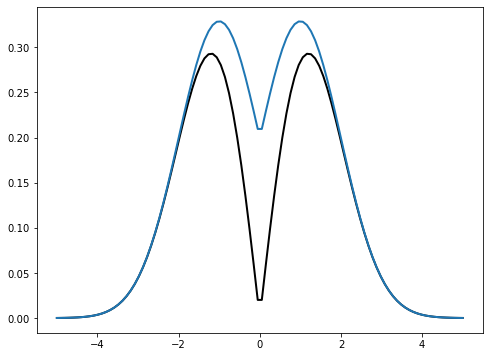

In [42]:
def gauss(x):
    return 1.0/np.sqrt(2*np.pi) * np.exp(-x**2/2)
x = np.linspace(-5, +5, 100)
f1 = np.multiply( np.sinh(np.abs(x)), gauss(x) )
f2 = np.multiply( 1/2*np.exp(np.abs(x)), gauss(x) )
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, f1, lw=2.0, c='k')
ax.plot(x, f2, lw=2.0, c='C0')
plt.show()